In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications import DenseNet201


In [2]:
disease_types=['COVID', 'non-COVID']
data_dir = '../input/sarscov2-ctscan-dataset'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (230).png,0,COVID
1,COVID/Covid (1195).png,0,COVID
2,COVID/Covid (182).png,0,COVID
3,COVID/Covid (817).png,0,COVID
4,COVID/Covid (631).png,0,COVID


In [4]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (54).png,0,COVID
1,COVID/Covid (1035).png,0,COVID
2,non-COVID/Non-Covid (21).png,1,non-COVID
3,non-COVID/Non-Covid (248).png,1,non-COVID
4,COVID/Covid (409).png,0,COVID


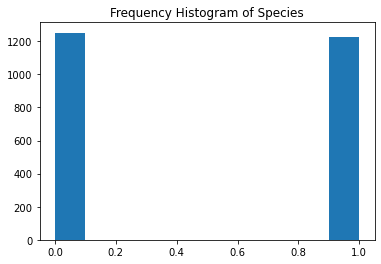

<Figure size 864x864 with 0 Axes>

In [5]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

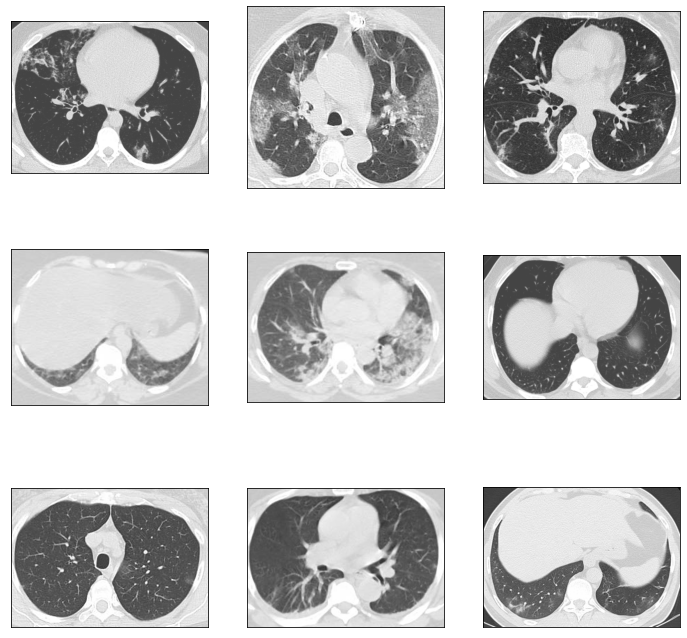

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 3, 3)

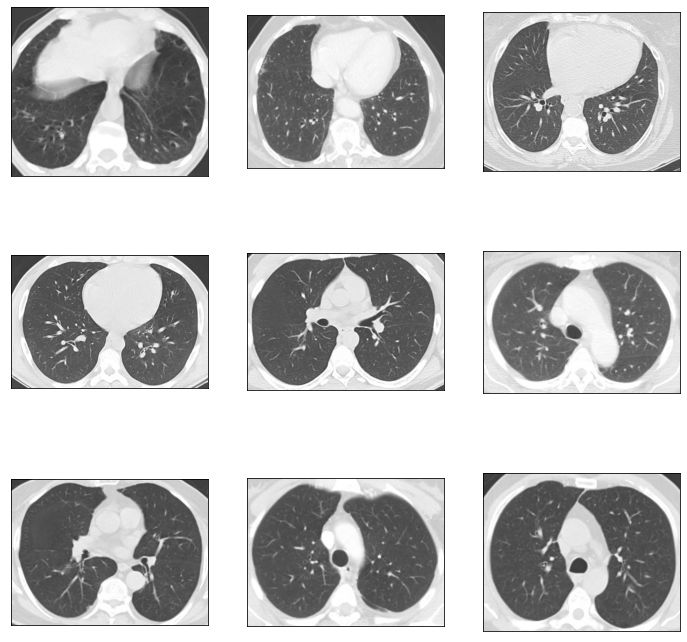

In [7]:
# Displays first n images of class from training set
plot_defects('non-COVID', 3, 3)

In [8]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:32, 77.47it/s]


Train Shape: (2481, 224, 224, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2481, 2)


In [11]:
BATCH_SIZE = 32

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)


In [12]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1984, 224, 224, 3)
X_val: (497, 224, 224, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


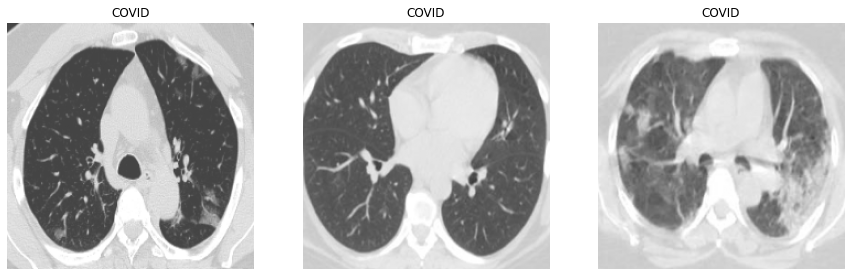

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [14]:
EPOCHS = 150
SIZE=224
N_ch=3

In [15]:
def build_resnet50():
    densetnet201 = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(224, 224, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densetnet201(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [16]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=10, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=20, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        horizontal_flip=True) # Randomly flip inputs horizontally


datagen.fit(X_train)


74842112/74836368 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       84        
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 128)               245888    
_______________________________________________________

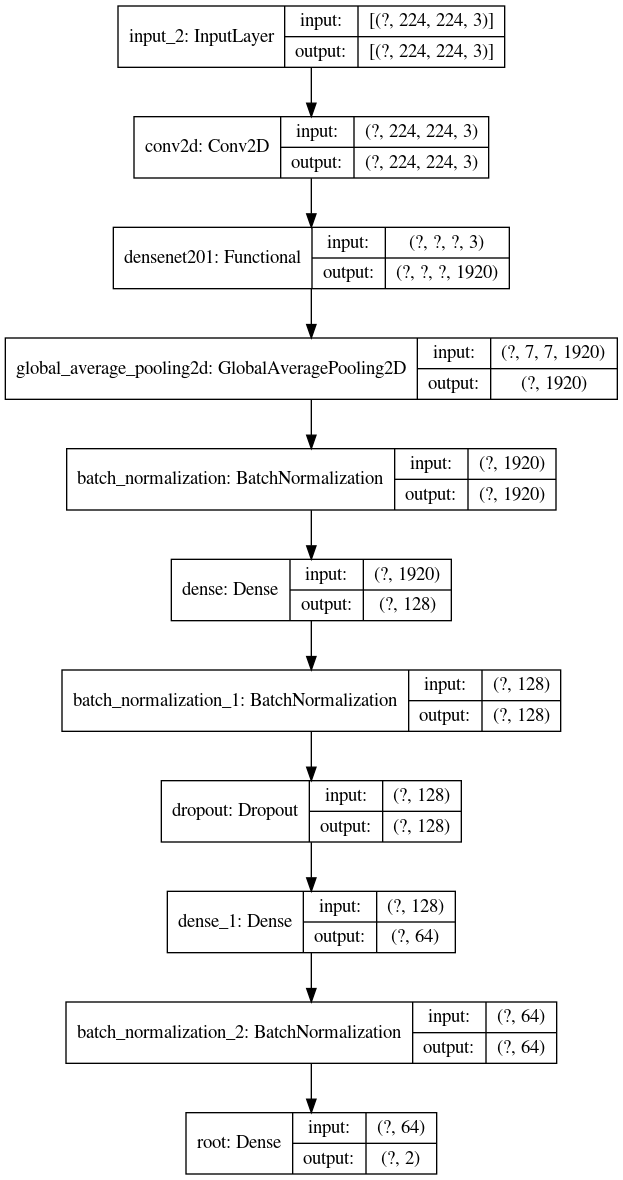

In [17]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [18]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/150
62/62 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7434
Epoch 00001: val_loss improved from inf to 0.73062, saving model to model.h5
62/62 [==============================] - 36s 574ms/step - loss: 0.5618 - accuracy: 0.7434 - val_loss: 0.7306 - val_accuracy: 0.5614
Epoch 2/150
62/62 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8684
Epoch 00002: val_loss did not improve from 0.73062
62/62 [==============================] - 29s 475ms/step - loss: 0.3151 - accuracy: 0.8684 - val_loss: 0.8943 - val_accuracy: 0.5594
Epoch 3/150
62/62 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9057
Epoch 00003: val_loss did not improve from 0.73062
62/62 [==============================] - 29s 466ms/step - loss: 0.2193 - accuracy: 0.9057 - val_loss: 1.1707 - val_accuracy: 0.5513
Epoch 4/150
62/62 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9274
Epoch 00004: val_loss did not improve from 0.

In [19]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 1s 82ms/step - loss: 0.0019 - accuracy: 1.0000
Final Loss: 0.0018544222693890333, Final Accuracy: 1.0


Text(0.5, 145.31999999999996, 'Predicted')

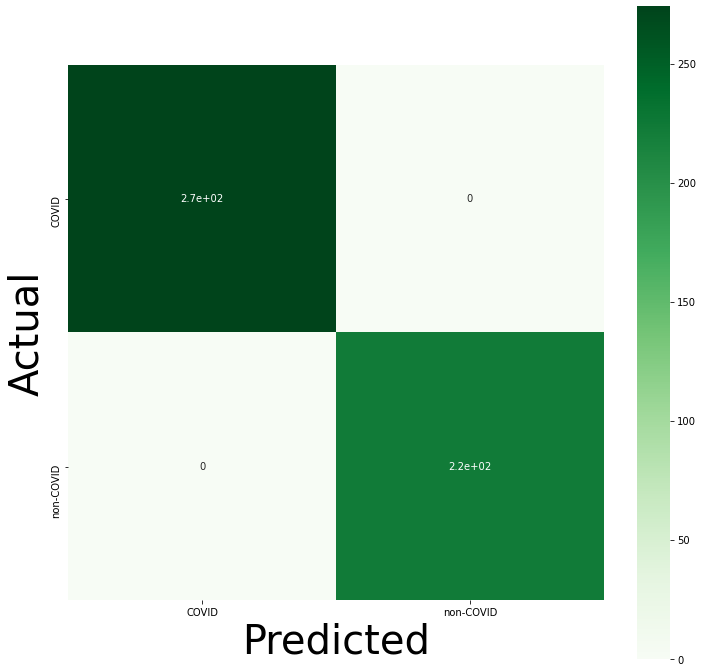

In [20]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [21]:
'''FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)'''

TN = cm[0][0]
#print(TN)
FN = cm[1][0]
#print(FN)
TP = cm[1][1]
#print(TP)
FP = cm[0][1]
#print(FP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print(TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP)
print(TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
print(FNR)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)

1.0
1.0
0.0
1.0


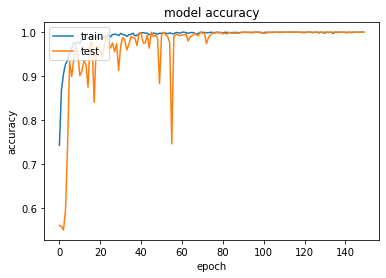

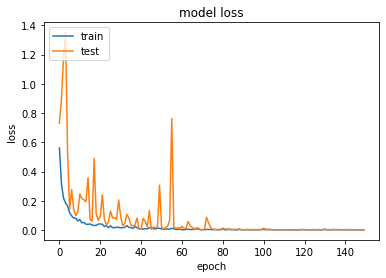

In [22]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()